In [1]:
!pip install tensorflow
!pip install tensorflow-recommenders
!pip intsall wordcloud

ERROR: unknown command "intsall" - maybe you meant "install"



In [2]:
!pip install wordcloud

In [3]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
credits = pd.read_csv('D:\data science projects dailys\dataset\mov\credits.csv')
keywords = pd.read_csv('D:\data science projects dailys\dataset\mov\keywords.csv')
movies = pd.read_csv('D:\data science projects dailys\dataset\mov\movies_metadata.csv', dtype={10: 'str'}).\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [5]:
df.head


<bound method NDFrame.head of        adult    budget                                             genres  \
0      False  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1      False  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2      False         0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3      False  16000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4      False         0                     [{'id': 35, 'name': 'Comedy'}]   
...      ...       ...                                                ...   
46622  False         0  [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...   
46624  False         0                      [{'id': 18, 'name': 'Drama'}]   
46625  False         0  [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...   
46626  False         0                                                 []   
46627  False         0                                                 []   

           id original_language              

In [6]:
print(df.columns)


Index(['adult', 'budget', 'genres', 'id', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'vote_average', 'vote_count', 'keywords',
       'cast', 'crew'],
      dtype='object')


In [7]:
df.info

<bound method DataFrame.info of        adult    budget                                             genres  \
0      False  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1      False  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2      False         0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3      False  16000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4      False         0                     [{'id': 35, 'name': 'Comedy'}]   
...      ...       ...                                                ...   
46622  False         0  [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...   
46624  False         0                      [{'id': 18, 'name': 'Drama'}]   
46625  False         0  [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...   
46626  False         0                                                 []   
46627  False         0                                                 []   

           id original_language            

In [8]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

# Visualization

(0.0, 2.0, 0.9, 1.2)

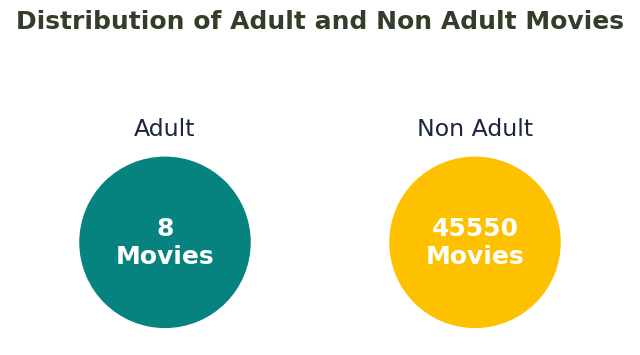

In [9]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

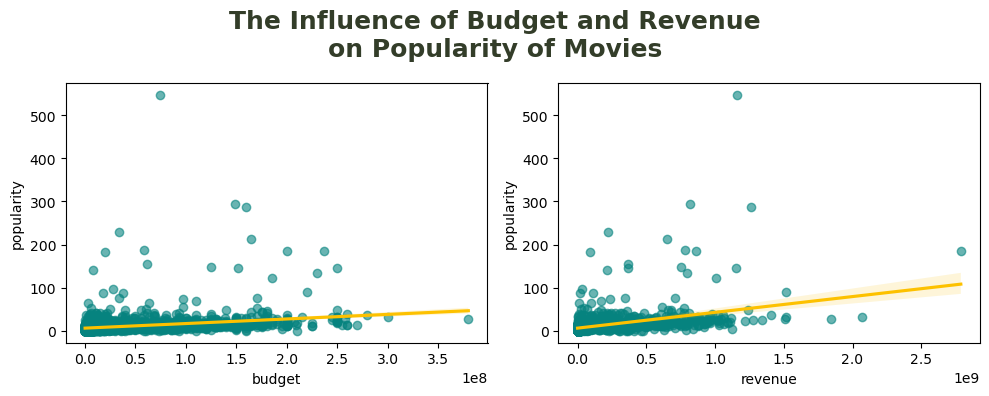

In [10]:
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

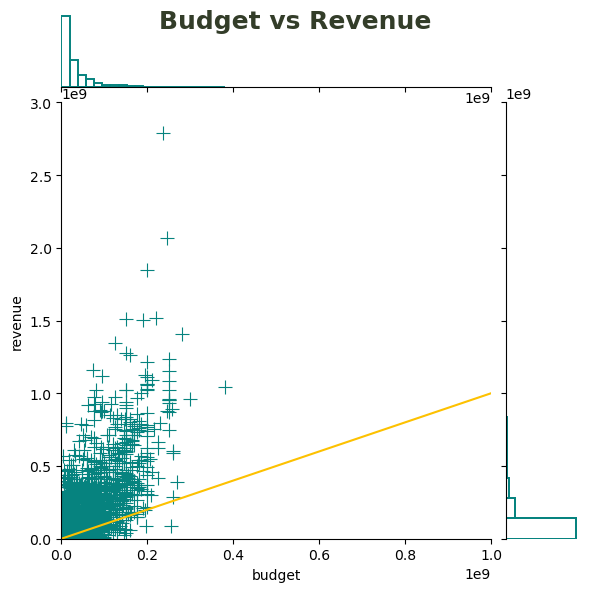

In [11]:
ax = sns.jointplot(data=df[(df['budget'] != 0) & (df['revenue'] != 0)], x='budget', y='revenue',
                   marker="+", s=100, marginal_kws=dict(bins=20, fill=False), color='#06837f')
ax.fig.suptitle('Budget vs Revenue', fontsize=18, weight=600, color='#333d29')
ax.ax_joint.set_xlim(0, 1e9)
ax.ax_joint.set_ylim(0, 3e9)
ax.ax_joint.axline((1,1), slope=1, color='#fdc100')

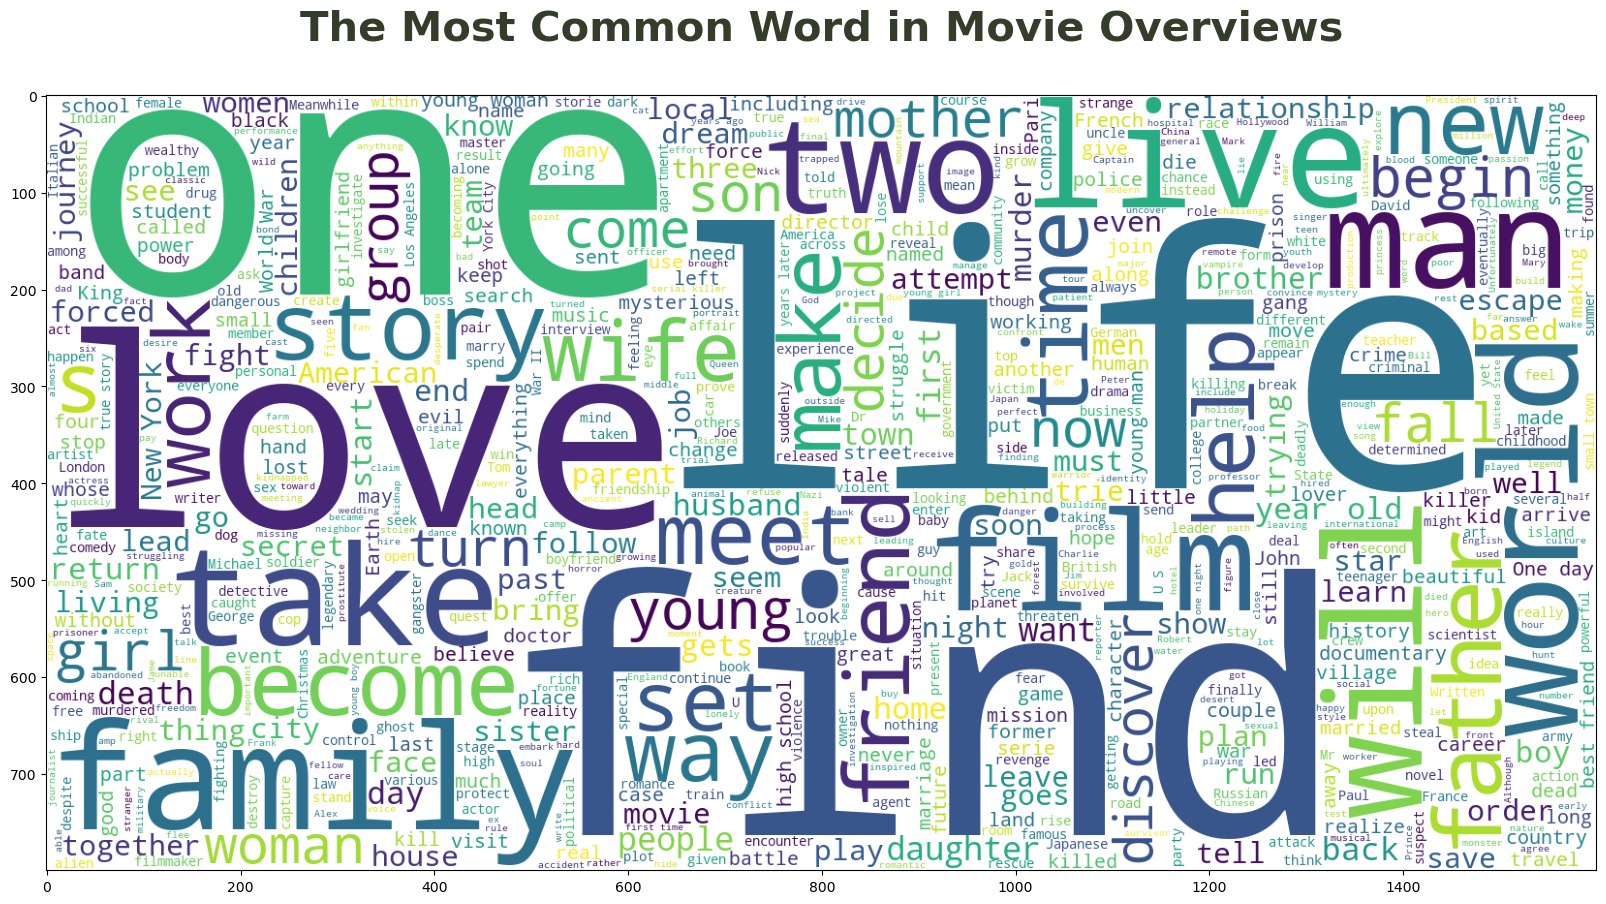

In [12]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(df['overview']))

plt.imshow(wc)

Word "life", "one", "find", "love" apparently appear in many occasions

(-1.25, 1.25, -1.25, 1.25)

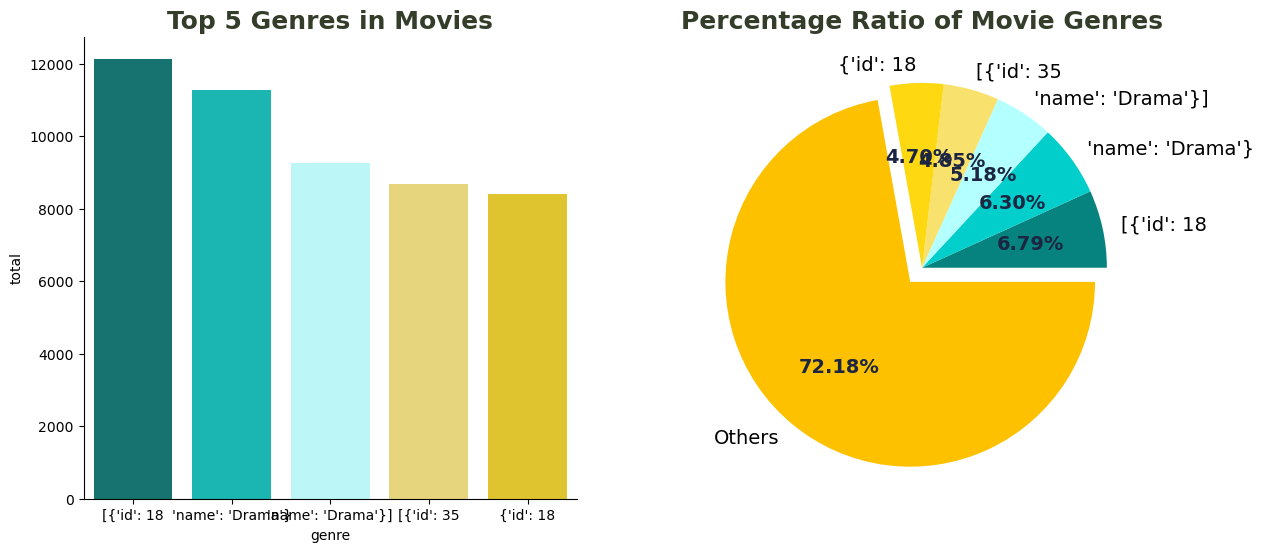

In [13]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

F:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Total Released Movie by Date')

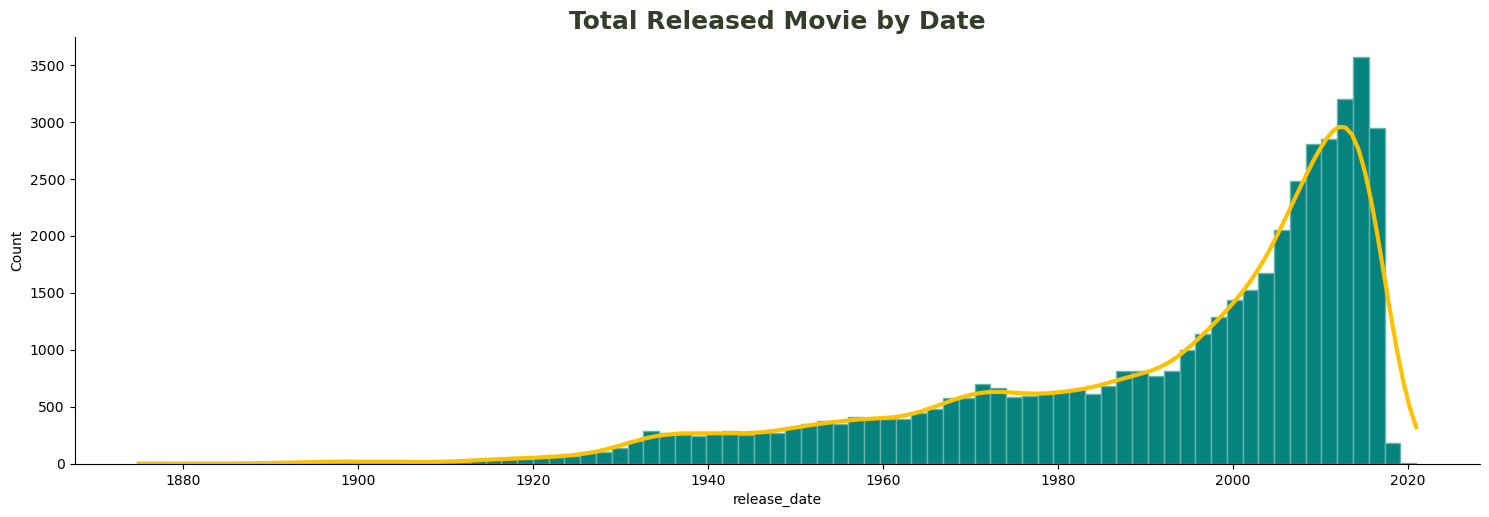

In [14]:
sns.displot(data=df, x='release_date', kind='hist', kde=True,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29')

In [19]:
df = df.replace({True: 1, False: 0})


In [21]:
df = df.select_dtypes(include=[np.number])


<Axes: title={'center': 'Correlation of Movie Features\n'}>

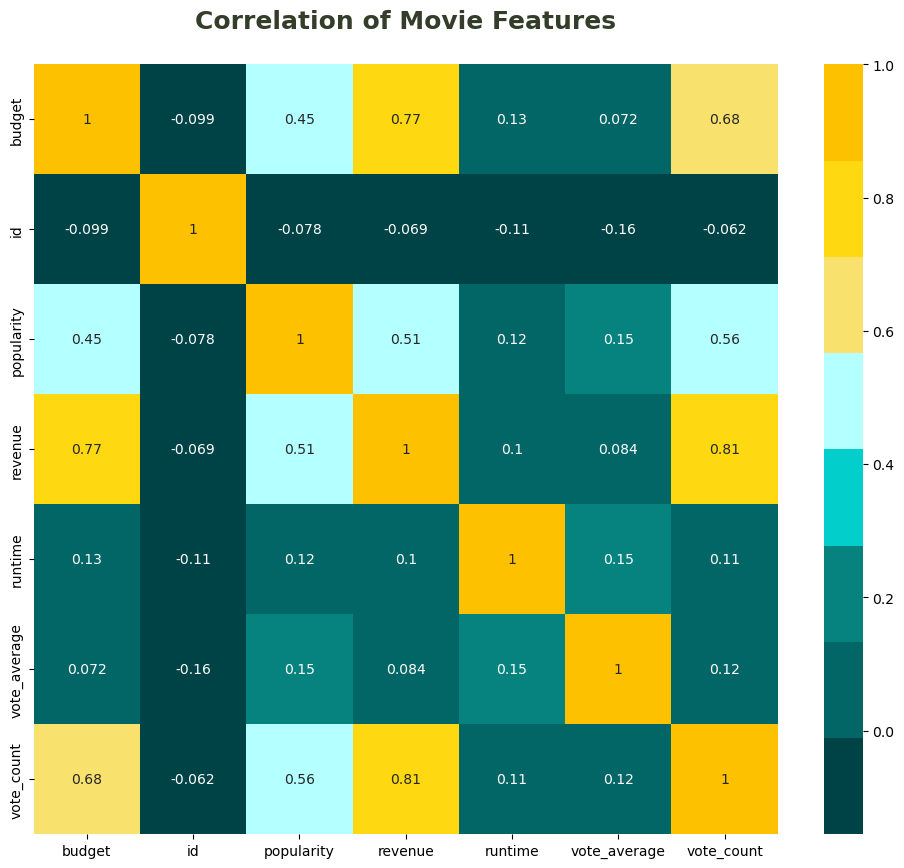

In [22]:
plt.figure(figsize=(12,10))
plt.title('Correlation of Movie Features\n', fontsize=18, weight=600, color='#333d29')
sns.heatmap(df.corr(), annot=True, cmap=['#004346', '#036666', '#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

In [34]:
credits = pd.read_csv('D:\data science projects dailys\dataset\mov\credits.csv')
keywords = pd.read_csv('D:\data science projects dailys\dataset\mov\keywords.csv')
movies = pd.read_csv('D:\data science projects dailys\dataset\mov\movies_metadata.csv', dtype={10: 'str'}).\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

# Hybrid

In [35]:
R = df['vote_average']
v = df['vote_count']
# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = df['vote_count'].quantile(0.8)
C = df['vote_average'].mean()

df['weighted_average'] = (R*v + C*m)/(v+m)

In [36]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

In [37]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6

In [38]:
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.604130,0.841652
Wonder Woman,0.537613,0.731646,0.615227
Beauty and the Beast,0.524675,0.668097,0.582044
Big Hero 6,0.390602,0.827923,0.565530
Baby Driver,0.416507,0.728163,0.541169
Guardians of the Galaxy Vol. 2,0.338511,0.795258,0.521210
Pulp Fiction,0.257449,0.908675,0.517939
Deadpool,0.343132,0.765098,0.511918
Gone Girl,0.282748,0.843757,0.507151


In [42]:
print(df.columns)


Index(['adult', 'budget', 'genres', 'id', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'vote_average', 'vote_count', 'keywords',
       'cast', 'crew', 'weighted_average'],
      dtype='object')


In [44]:
hybrid_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew']]

In [45]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)



In [46]:
def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text
hybrid_df['adult'] = hybrid_df['adult'].apply(remove_punc)
hybrid_df['genres'] = hybrid_df['genres'].apply(remove_punc)
hybrid_df['overview'] = hybrid_df['overview'].apply(remove_punc)
hybrid_df['production_companies'] = hybrid_df['production_companies'].apply(separate)
hybrid_df['tagline'] = hybrid_df['tagline'].apply(remove_punc)
hybrid_df['keywords'] = hybrid_df['keywords'].apply(separate)
hybrid_df['crew'] = hybrid_df['crew'].apply(separate)

hybrid_df['bag_of_words'] = ''
hybrid_df['bag_of_words'] = hybrid_df[hybrid_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
hybrid_df.set_index('original_title', inplace=True)

hybrid_df = hybrid_df[['bag_of_words']]
hybrid_df.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_14636\2920750065.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hybrid_df['adult'] = hybrid_df['adult'].apply(remove_punc)
C:\Users\DELL\AppData\Local\Temp\ipykernel_14636\2920750065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hybrid_df['genres'] = hybrid_df['genres'].apply(remove_punc)
C:\Users\DELL\AppData\Local\Temp\ipykernel_14636\2920750065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,bag_of_words
original_title,
Toy Story,false id name animation id name comedy id n...
Jumanji,false id name adventure id name fantasy id ...
Grumpier Old Men,false id name romance id name comedy a famil...
Waiting to Exhale,false id name comedy id name drama id name ...
Father of the Bride Part II,false id name comedy just when george banks h...


In [47]:
hybrid_df = weighted_df_sorted[:10000].merge(hybrid_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(hybrid_df['bag_of_words'])
tfidf_matrix.shape

(12171, 31779)

In [48]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(12171, 12171)

In [49]:
hybrid_df

,popularity,weighted_average,score,bag_of_words
original_title,,,,
'71,0.012933,0.634956,0.261742,false id name thriller id name action id na...
(500) Days of Summer,0.029912,0.729960,0.309931,false id name comedy id name drama id name ...
(Dis)Honesty: The Truth About Lies,0.002240,0.537258,0.216247,false id name documentary a documentary about...
*batteries not included,0.020991,0.569421,0.240363,false id name comedy id name family id name...
...And Justice for All,0.011492,0.647043,0.265712,false id name crime id name drama id name m...
...,...,...,...,...
화차,0.003946,0.548773,0.221877,false id name mystery id name thriller a wom...
활,0.004963,0.566487,0.229573,false id name drama id name romance on a fis...
황해,0.008353,0.665502,0.271213,false id name drama id name thriller id nam...


In [50]:
hybrid_df.reset_index()

,original_title,popularity,weighted_average,score,bag_of_words
0,'71,0.012933,0.634956,0.261742,false id name thriller id name action id na...
1,(500) Days of Summer,0.029912,0.729960,0.309931,false id name comedy id name drama id name ...
2,(Dis)Honesty: The Truth About Lies,0.002240,0.537258,0.216247,false id name documentary a documentary about...
3,*batteries not included,0.020991,0.569421,0.240363,false id name comedy id name family id name...
4,...And Justice for All,0.011492,0.647043,0.265712,false id name crime id name drama id name m...
...,...,...,...,...,...
12166,화차,0.003946,0.548773,0.221877,false id name mystery id name thriller a wom...
12167,활,0.004963,0.566487,0.229573,false id name drama id name romance on a fis...
12168,황해,0.008353,0.665502,0.271213,false id name drama id name thriller id nam...
12169,회사원,0.011437,0.560903,0.231224,false id name drama id name action hyeongdo ...


In [51]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = hybrid_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T
    
    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    # You can also play around with the number
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight
    
    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [52]:
predict('Toy Story', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
original_title,,,
Toy Story,0.348666,1.000000,0.804600
Toy Story 2,0.317960,0.888092,0.717053
"Monsters, Inc.",0.340947,0.797036,0.660209
Wonder Woman,0.615227,0.678222,0.659323
The Boxtrolls,0.263451,0.820824,0.653612
Bolt,0.251638,0.815353,0.646239
Coraline,0.314661,0.788111,0.646076
"South Park: Bigger, Longer & Uncut",0.295218,0.792142,0.643065
もののけ姫,0.372827,0.752535,0.638623


In [ ]:
#for converting dataframe into csv
#hybrid_df.to_csv('hybridnew_df.csv')

# Deep Learning

In [53]:
ratings_df = pd.read_csv('D:/data science projects dailys/dataset/mov/ratings_small.csv')

ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,1,1371,2.5,2009-12-13 21:52:15,Rocky III,"[{'id': 18, 'name': 'Drama'}]","Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-13 21:53:23,Greed,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-13 21:52:19,American Pie,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-13 21:53:18,My Tutor,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-13 21:51:48,Jay and Silent Bob Strike Back,"[{'id': 35, 'name': 'Comedy'}]",When Jay and Silent Bob learn that their comic...


In [54]:
movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_14636\1980486665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df.rename(columns={'id':'movieId'}, inplace=True)


,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [55]:
ratings_df['userId'] = ratings_df['userId'].astype(str)

ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

In [56]:
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

Total Data: 44875


In [57]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 42373
Unique users: 671


In [59]:
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])
        
    self.rating_model = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

In [62]:
def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )
def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

In [64]:
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

In [65]:
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

model.fit(cached_train, epochs=3)

Epoch 1/3
35/35 [==============================] - 62s 2s/step - root_mean_squared_error: 1.6698 - factorized_top_k/top_1_categorical_accuracy: 3.7143e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0054 - factorized_top_k/top_10_categorical_accuracy: 0.0152 - factorized_top_k/top_50_categorical_accuracy: 0.0895 - factorized_top_k/top_100_categorical_accuracy: 0.1533 - loss: 6815.1948 - regularization_loss: 0.0000e+00 - total_loss: 6815.1948
Epoch 2/3
35/35 [==============================] - 62s 2s/step - root_mean_squared_error: 1.0146 - factorized_top_k/top_1_categorical_accuracy: 8.5714e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0165 - factorized_top_k/top_10_categorical_accuracy: 0.0380 - factorized_top_k/top_50_categorical_accuracy: 0.1788 - factorized_top_k/top_100_categorical_accuracy: 0.2934 - loss: 6453.6019 - regularization_loss: 0.0000e+00 - total_loss: 6453.6019
Epoch 3/3
35/35 [==============================] - 62s 2s/step - root_mean_squared_error: 0.9919 -

In [66]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

9/9 [==============================] - 9s 868ms/step - root_mean_squared_error: 0.9837 - factorized_top_k/top_1_categorical_accuracy: 9.7704e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0054 - factorized_top_k/top_10_categorical_accuracy: 0.0084 - factorized_top_k/top_50_categorical_accuracy: 0.0414 - factorized_top_k/top_100_categorical_accuracy: 0.0755 - loss: 5724.7511 - regularization_loss: 0.0000e+00 - total_loss: 5724.7511

Retrieval top-100 accuracy: 0.075
Ranking RMSE: 0.984


In [67]:
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

In [68]:
predict_movie(123, 5)

Top 5 recommendations for user 123:

1. The Greatest Story Ever Told
2. Un long dimanche de fiançailles
3. Batoru rowaiaru II: Chinkonka
4. Azuloscurocasinegro
5. The Mask of Fu Manchu


In [69]:
predict_rating(123,'(500) Days of Summer')

Predicted rating for (500) Days of Summer: 3.518547296524048


In [70]:
predict_rating(123,'Minions')

Predicted rating for Minions: 3.461561679840088


In [71]:
ratings_df[ratings_df['userId'] == '123']

,userId,movieId,rating,date,original_title,genres,overview
8360,123,233,4.0,2001-07-01 16:57:06,The Wanderers,"[{'id': 18, 'name': 'Drama'}]",The streets of the Bronx are owned by 60’s you...
8361,123,288,5.0,2001-07-01 15:32:47,High Noon,"[{'id': 37, 'name': 'Western'}]",High Noon is about a recently freed leader of ...
8362,123,407,5.0,2001-07-01 16:57:57,Kurz und schmerzlos,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",Three friends get caught in a life of major cr...
8363,123,968,3.0,2001-07-01 16:59:01,Dog Day Afternoon,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",A man robs a bank to pay for his lover's opera...
8364,123,1968,4.0,2001-07-01 15:30:36,Fools Rush In,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",Alex Whitman (Matthew Perry) is a designer fro...
8365,123,1976,4.0,2001-07-01 15:31:51,Jezebel,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...","In 1850s Louisiana, the willfulness of a tempe..."
8366,123,2003,4.0,2001-07-01 15:31:51,Anatomie de l'enfer,"[{'id': 18, 'name': 'Drama'}]",A man rescues a woman from a suicide attempt i...
8367,123,2428,5.0,2001-07-01 16:57:06,The Greatest Story Ever Told,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",All-star epic retelling of Christ's life.
8368,123,2502,5.0,2001-07-01 16:59:01,The Bourne Supremacy,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",When a CIA operation to purchase classified Ru...
8369,123,2699,2.0,2001-07-01 16:55:42,Titanic,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",A story of the romances of two couples upon th...


In [72]:
# Get meta data for predicted movie
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(['123']))
pred_movies = pd.DataFrame({'original_title': [i.decode('utf-8') for i in titles[0,:5].numpy()]})

pred_df = pred_movies.merge(ratings_df[['original_title', 'genres', 'overview']], on='original_title', how='left')
pred_df = pred_df[~pred_df['original_title'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

pred_df

,original_title,genres,overview
1,The Greatest Story Ever Told,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",All-star epic retelling of Christ's life.
2,Un long dimanche de fiançailles,"[{'id': 18, 'name': 'Drama'}]","In 1919, Mathilde was 19 years old. Two years ..."
3,Batoru rowaiaru II: Chinkonka,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",It's three years after the events of the origi...
4,Azuloscurocasinegro,"[{'id': 18, 'name': 'Drama'}]",Jorge is a young man whose plans for the futur...
5,The Mask of Fu Manchu,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Boris Karloff stars as the villainous Dr. Fu M...


we can see if User 123 love watching Drama movies most of the time. He/She also gives a good rating for that genre. In our recommendation, We give 5 more Drama movies that we expect him/her to love the movies in a similar way with the previous watched movies.

In our dataset, we don't see any Animation movies that have been watched by User 123. So, it's not a surprise if the estimated rating for (500) Days of Summer & Minions is quite low